In [2]:
import pandas as pd
import kagglehub
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import normalize
!pip install kagglehub


In [3]:
# file_path= r"/content/data.csv"
# df = pd.read_csv("/content/data.csv", encoding='ISO-8859-1')
# df.head()


In [4]:
# Download latest version
path = kagglehub.dataset_download("carrie1/ecommerce-data")


In [5]:
from pathlib import Path
Path(path).iterdir()

<generator object Path.iterdir at 0x7f367f0097e0>

In [6]:
print(os.listdir(path))

['data.csv']


In [7]:
csv_files = [file for file in os.listdir(path) if file.endswith('.csv')]
print("CSV files:", csv_files)

if csv_files:
    df = pd.read_csv(os.path.join(path, csv_files[0]), encoding='ISO-8859-1')  # or UTF-8 depending on file
    print("Loaded DataFrame shape:", df.shape)
else:
    print("No CSV file found in the dataset.")

CSV files: ['data.csv']
Loaded DataFrame shape: (541909, 8)


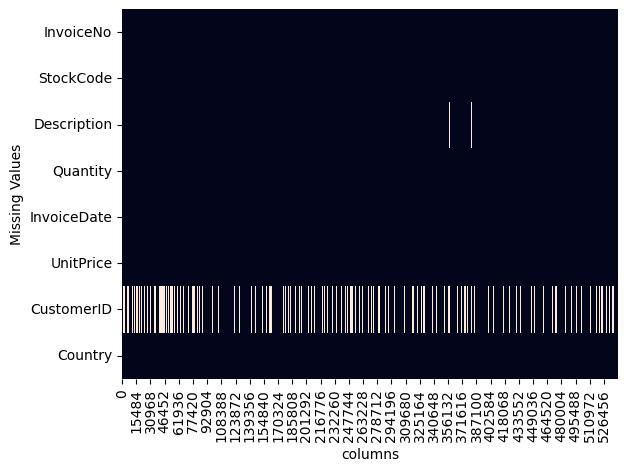

In [8]:
ax = plt.axes()
sns.heatmap(df.isna().transpose(),cbar=False, ax=ax)

plt.xlabel("columns")
plt.ylabel("Missing Values")
plt.show()

In [9]:
df.columns = df.columns.str.strip()
df = df[df['Quantity']>0]
df.Quantity.describe()
#checking null values in all columns in dataset
df = df.dropna(subset=['CustomerID','Description']).copy()
df.columns = df.columns.str.strip()  # removes leading/trailing spaces
df = df[~df['StockCode'].str.match(r'^[A-Za-z]+$', na=False)] # Drop rows where StockCode contains only letters (no numbers)
df = df[df['StockCode'] != 'BANK CHARGES']
country_to_district = {
    # Europe
    'United Kingdom': 'Europe',
    'France': 'Europe',
    'Germany': 'Europe',
    'Spain': 'Europe',
    'Portugal': 'Europe',
    'Italy': 'Europe',
    'Netherlands': 'Europe',
    'Switzerland': 'Europe',
    'Belgium': 'Europe',
    'Austria': 'Europe',
    'Sweden': 'Europe',
    'Finland': 'Europe',
    'Denmark': 'Europe',
    'Norway': 'Europe',
    'Lithuania': 'Europe',
    'Greece': 'Europe',
    'Poland': 'Europe',
    'Cyprus': 'Europe',
    'Malta': 'Europe',
    'Iceland': 'Europe',
    'Channel Islands': 'Europe',
    'European Community': 'Europe',

    # Middle East
    'Saudi Arabia': 'Middle East',
    'Lebanon': 'Middle East',
    'United Arab Emirates': 'Middle East',
    'Israel': 'Middle East',
    'Bahrain': 'Middle East',

    # Asia-Pacific
    'Japan': 'Asia-Pacific',
    'Singapore': 'Asia-Pacific',

    # North America
    'USA': 'North America',
    'Canada': 'North America',

    # Other
    'Australia': 'Oceania',
    'EIRE': 'Europe',
    'Brazil': 'South America',
    'RSA': 'Africa',
    'Czech Republic': 'Europe',
    'Unspecified': 'Unknown'
}
df['District'] = df['Country'].map(country_to_district)

df.drop_duplicates(inplace=True)

/tmp/ipython-input-9-4167272889.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['District'] = df['Country'].map(country_to_district)


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 391316 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    391316 non-null  object 
 1   StockCode    391316 non-null  object 
 2   Description  391316 non-null  object 
 3   Quantity     391316 non-null  int64  
 4   InvoiceDate  391316 non-null  object 
 5   UnitPrice    391316 non-null  float64
 6   CustomerID   391316 non-null  float64
 7   Country      391316 non-null  object 
 8   District     391316 non-null  object 
dtypes: float64(2), int64(1), object(6)
memory usage: 29.9+ MB


In [11]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,391316.000000,391316.000000,391316.000000
mean,13.175528,2.890193,15294.841072
std,181.876625,4.375175,1710.167127
min,1.000000,0.000000,12346.000000
25%,2.000000,1.250000,13969.000000
50%,6.000000,1.950000,15157.000000
75%,12.000000,3.750000,16794.000000
max,80995.000000,649.500000,18287.000000


In [12]:
descriptions = df['Description'].dropna().unique()
clean_descriptions = [desc for desc in descriptions if isinstance(desc, str) and len(desc.strip()) > 5]


model = SentenceTransformer('all-MiniLM-L6-v2')


embeddings = model.encode(clean_descriptions, show_progress_bar=True)




/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/121 [00:00<?, ?it/s]

In [13]:
cos_sim_matrix = cosine_similarity(embeddings)


similarity_threshold = 0.60
n = len(clean_descriptions)
group_labels = [-1] * n
current_group = 0


for i in range(n):
    if group_labels[i] == -1:
        group_labels[i] = current_group
        for j in range(i + 1, n):
            if group_labels[j] == -1 and cos_sim_matrix[i][j] >= similarity_threshold:
                group_labels[j] = current_group
        current_group += 1


desc_to_group = dict(zip(clean_descriptions, group_labels))
df['Description_Categorize'] = df['Description'].map(desc_to_group)


In [14]:
print(df[['Description', 'Description_Categorize']])


                                Description  Description_Categorize
0        WHITE HANGING HEART T-LIGHT HOLDER                       0
1                       WHITE METAL LANTERN                       1
2            CREAM CUPID HEARTS COAT HANGER                       2
3       KNITTED UNION FLAG HOT WATER BOTTLE                       3
4            RED WOOLLY HOTTIE WHITE HEART.                       4
...                                     ...                     ...
541904          PACK OF 20 SPACEBOY NAPKINS                     501
541905         CHILDREN'S APRON DOLLY GIRL                       28
541906        CHILDRENS CUTLERY DOLLY GIRL                      228
541907      CHILDRENS CUTLERY CIRCUS PARADE                      30
541908        BAKING SET 9 PIECE RETROSPOT                      251

[391316 rows x 2 columns]


In [15]:
grouped_descriptions = df[['Description', 'Description_Categorize']].dropna().groupby('Description_Categorize')['Description'].unique()

for group_id, descriptions in grouped_descriptions.items():
    print(f"\n🔹 Group {group_id} ({len(descriptions)} items):")
    for desc in descriptions:
        print(f"  - {desc}")



🔹 Group 0 (61 items):
  - WHITE HANGING HEART T-LIGHT HOLDER
  - RED HANGING HEART T-LIGHT HOLDER
  - COLOUR GLASS T-LIGHT HOLDER HANGING
  - HANGING METAL HEART LANTERN
  - FIVE HEART HANGING DECORATION
  - HANGING HEART ZINC T-LIGHT HOLDER
  - VICTORIAN GLASS HANGING T-LIGHT
  - SINGLE HEART ZINC T-LIGHT HOLDER
  - SILVER HANGING T-LIGHT HOLDER
  - BLACK CANDELABRA T-LIGHT HOLDER
  - AGED GLASS SILVER T-LIGHT HOLDER
  - CHRISTMAS TREE T-LIGHT HOLDER
  - STAR  T-LIGHT HOLDER 
  - HEART T-LIGHT HOLDER 
  - T-LIGHT HOLDER HANGING LACE
  - HANGING HEART MIRROR DECORATION 
  - MULTI COLOUR SILVER T-LIGHT HOLDER
  - COLOUR GLASS. STAR T-LIGHT HOLDER
  - HANGING BAUBLE T-LIGHT HOLDER SMALL
  - GLASS HEART T-LIGHT HOLDER 
  - WHITE JEWELLED HEART DECORATION
  - HANGING BAUBLE T-LIGHT HOLDER LARGE
  - PINK TALL PORCELAIN T-LIGHT HOLDER 
  - WHITE TALL PORCELAIN T-LIGHT HOLDER
  - MIRROR LOVE BIRD T-LIGHT HOLDER
  - BLACK LOVE BIRD T-LIGHT HOLDER
  - HANGING JAM JAR T-LIGHT HOLDER
  - ASSORTE

In [16]:
group_representatives = df.groupby('Description_Categorize')['Description'].first()
group_to_label = group_representatives.to_dict()

In [20]:
# Get Unique Value of CustomerID
unique_customers = df['CustomerID'].unique()
print(unique_customers)


[17850. 13047. 12583. ... 13298. 14569. 12713.]


In [21]:
df['CustomerID'].nunique()


4335

In [22]:
top_customers = df['CustomerID'].value_counts().head(10)
print(top_customers)

CustomerID
17841.0    7667
14911.0    5670
14096.0    5095
12748.0    4397
14606.0    2674
15311.0    2366
14646.0    2064
13089.0    1814
13263.0    1662
14298.0    1637
Name: count, dtype: int64


In [23]:
# Create New column for total price for every Row
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [24]:
# Calculate the total price for every CustomerID
customer_total_spending = df.groupby('CustomerID')['TotalPrice'].sum()

# Add new Column for the total price for every CustomerID
df['Customer_TotalSpending'] = df['CustomerID'].map(customer_total_spending)

# Show each customer with their total without modification, in descending order.
df_unique_customers = df[['CustomerID', 'Customer_TotalSpending']].drop_duplicates().sort_values(by='Customer_TotalSpending', ascending=False)

# Print Results
print(df_unique_customers.head(20))





        CustomerID  Customer_TotalSpending
37952      14646.0               279138.02
16425      18102.0               259657.30
14059      17450.0               194390.79
194354     16446.0               168472.50
1404       14911.0               140336.83
45511      12415.0               124564.53
6364       14156.0               117210.08
211        17511.0                91062.38
61619      12346.0                77183.60
175        16029.0                72708.09
33864      16684.0                66653.56
728        13694.0                65039.62
106        15311.0                60632.75
7440       13089.0                58762.08
6607       17949.0                58030.48
7149       15769.0                56252.72
4439       15061.0                54534.14
317502     14096.0                53258.43
29815      14298.0                51527.30
66269      14088.0                50491.81


In [25]:
print(df.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'District',
       'Description_Categorize', 'TotalPrice', 'Customer_TotalSpending'],
      dtype='object')


In [26]:
df.columns = df.columns.str.strip()
df[['TotalPrice']]



,TotalPrice
0,15.30
1,20.34
2,22.00
3,20.34
4,20.34
...,...
541904,10.20
541905,12.60
541906,16.60
541907,16.60


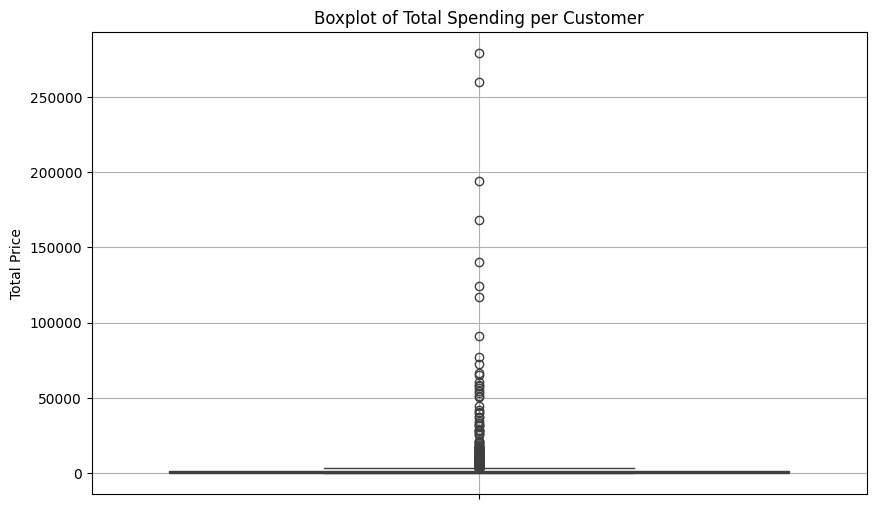

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=df_unique_customers['Customer_TotalSpending'])
plt.title("Boxplot of Total Spending per Customer")
plt.ylabel("Total Price")
plt.grid(True)
plt.show()

In [28]:
df.groupby('Description').agg({"Quantity":"sum"}).sort_values("Quantity", ascending=False).head(10)

,Quantity
Description,
"PAPER CRAFT , LITTLE BIRDIE",80995
MEDIUM CERAMIC TOP STORAGE JAR,77916
WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
JUMBO BAG RED RETROSPOT,46078
WHITE HANGING HEART T-LIGHT HOLDER,36706
ASSORTED COLOUR BIRD ORNAMENT,35263
PACK OF 72 RETROSPOT CAKE CASES,33670
POPCORN HOLDER,30919
RABBIT NIGHT LIGHT,27153


In [29]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,District,Description_Categorize,TotalPrice,Customer_TotalSpending
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,Europe,0,15.30,5391.21
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Europe,1,20.34,5391.21
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,Europe,2,22.00,5391.21
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Europe,3,20.34,5391.21
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,Europe,4,20.34,5391.21
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,Europe,501,10.20,790.81
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,Europe,28,12.60,790.81
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,Europe,228,16.60,790.81
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,Europe,30,16.60,790.81


#RFM Analysis

In [30]:
import datetime as dt

In [31]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


In [32]:
df["InvoiceDate"].max()

Timestamp('2011-12-09 12:50:00')

In [33]:
today_date = dt.datetime(2011, 12, 11)

In [34]:
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda date : (today_date - date.max()).days,  # Recency
    "InvoiceNo": lambda num: num.nunique(),                        # Frequency
    "TotalPrice": lambda TotalPrice: TotalPrice.sum()})           # Monetry
rfm

,InvoiceDate,InvoiceNo,TotalPrice
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1437.24
12349.0,19,1,1457.55
12350.0,311,1,294.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [35]:
# إعادة التسمية
rfm.columns = [ "Recency", "Frequency", "Monetary" ]
rfm


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1437.24
12349.0,19,1,1457.55
12350.0,311,1,294.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [36]:
rfm = rfm[rfm["Monetary"] > 0 ]
rfm

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,1,77183.60
12347.0,3,7,4310.00
12348.0,76,4,1437.24
12349.0,19,1,1457.55
12350.0,311,1,294.40
...,...,...,...
18280.0,278,1,180.60
18281.0,181,1,80.82
18282.0,8,2,178.05


In [37]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
Recency,4334.0,93.226581,100.175327,1.00,18.000,51.00,143.0000,374.00
Frequency,4334.0,4.247116,7.644603,1.00,1.000,2.00,5.0000,206.00
Monetary,4334.0,2017.515838,8920.363571,3.75,304.305,663.71,1631.6225,279138.02


In [38]:
rfm["recency_score"]= pd.qcut(rfm["Recency"],5, labels=[5,4,3,2,1])

/tmp/ipython-input-38-1598232843.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["recency_score"]= pd.qcut(rfm["Recency"],5, labels=[5,4,3,2,1])


In [39]:
rfm["frequency_score"]= pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])

/tmp/ipython-input-39-1538238694.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["frequency_score"]= pd.qcut(rfm["Frequency"].rank(method="first"), 5, labels=[1,2,3,4,5])


In [40]:
rfm["monetary_score"]= pd.qcut(rfm["Monetary"],5, labels=[1,2,3,4,5])

/tmp/ipython-input-40-1212404480.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["monetary_score"]= pd.qcut(rfm["Monetary"],5, labels=[1,2,3,4,5])


In [41]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
CustomerID,,,,,,
12346.0,326,1,77183.60,1,1,5
12347.0,3,7,4310.00,5,5,5
12348.0,76,4,1437.24,2,4,4
12349.0,19,1,1457.55,4,1,4
12350.0,311,1,294.40,1,1,2


In [42]:
rfm.sample(10)

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score
CustomerID,,,,,,
17159.0,22,3,1538.88,4,4,4
16751.0,31,1,1764.72,4,2,4
15732.0,213,2,294.12,1,3,2
18077.0,9,11,2584.41,5,5,5
12386.0,338,2,401.90,1,2,2
12506.0,233,1,73.50,1,1,1
12472.0,33,7,6068.11,4,5,5
13141.0,85,5,2388.75,2,4,5
15497.0,18,2,1262.20,4,3,4


In [43]:
rfm["RFM_SCORE"] = (rfm["recency_score"]).astype(str) + rfm["frequency_score"].astype(str)

/tmp/ipython-input-43-1055947711.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm["RFM_SCORE"] = (rfm["recency_score"]).astype(str) + rfm["frequency_score"].astype(str)


In [44]:
rfm.head()

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
12346.0,326,1,77183.60,1,1,5,11
12347.0,3,7,4310.00,5,5,5,55
12348.0,76,4,1437.24,2,4,4,24
12349.0,19,1,1457.55,4,1,4,41
12350.0,311,1,294.40,1,1,2,11


In [45]:
# Segmenting Customers Using RFM Score
seg_map = {

  r'[1-2][1-2]': 'hibernating',

  r'[1-2][3-4]': 'at_Risk',

  r'[1-2]5': 'cant_loose',

  r'3[1-2]': 'about_to_sleep',

  r'33': 'need_attention',

  r'[3-4][4-5]': 'loyal_customers',

  r'41': 'promising',

  r'51': 'new_customers',

  r'[4-5][2-3]': 'potential_loyalists',

  r'5[4-5]': 'champions'

}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm.head()

/tmp/ipython-input-45-18459701.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)


,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1437.24,2,4,4,24,at_Risk
12349.0,19,1,1457.55,4,1,4,41,promising
12350.0,311,1,294.40,1,1,2,11,hibernating


In [46]:
rfm.sample(10)

,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
15562.0,352,1,134.55,1,1,1,11,hibernating
13694.0,4,50,65039.62,5,5,5,55,champions
15626.0,75,2,675.80,2,3,3,23,at_Risk
13460.0,30,2,183.44,4,2,1,42,potential_loyalists
14023.0,8,2,584.07,5,3,3,53,potential_loyalists
14805.0,16,4,546.40,4,4,3,44,loyal_customers
16433.0,29,1,184.26,4,2,1,42,potential_loyalists
17388.0,78,4,1259.56,2,4,4,24,at_Risk
13933.0,110,2,608.79,2,3,3,23,at_Risk


In [47]:
rfm = rfm.reset_index()
rfm

,CustomerID,Recency,Frequency,Monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
0,12346.0,326,1,77183.60,1,1,5,11,hibernating
1,12347.0,3,7,4310.00,5,5,5,55,champions
2,12348.0,76,4,1437.24,2,4,4,24,at_Risk
3,12349.0,19,1,1457.55,4,1,4,41,promising
4,12350.0,311,1,294.40,1,1,2,11,hibernating
...,...,...,...,...,...,...,...,...,...
4329,18280.0,278,1,180.60,1,2,1,12,hibernating
4330,18281.0,181,1,80.82,1,2,1,12,hibernating
4331,18282.0,8,2,178.05,5,3,1,53,potential_loyalists
4332,18283.0,4,16,2039.58,5,5,5,55,champions


In [48]:
rfm[['segment','Recency','Frequency','Monetary']].groupby("segment").agg(['mean','count','max']).round()

Recency            Frequency            Monetary        \
                       mean count  max      mean count  max     mean count   
segment                                                                      
about_to_sleep         53.0   348   72       1.0   348    2    470.0   348   
at_Risk               154.0   587  374       3.0   587    5   1074.0   587   
cant_loose            135.0    63  373       8.0    63   34   2728.0    63   
champions               7.0   655   15      12.0   655  206   6648.0   655   
hibernating           218.0  1074  374       1.0  1074    2    479.0  1074   
loyal_customers        34.0   798   72       6.0   798   62   2776.0   798   
need_attention         52.0   189   72       2.0   189    3    828.0   189   
new_customers           8.0    46   15       1.0    46    1    356.0    46   
potential_loyalists    17.0   484   33       2.0   484    3   1022.0   484   
promising              24.0    90   33       1.0    90    1    288.0    90   

                               
                          max  
segment                        
about_to_sleep         6208.0  
at_Risk               44534.0  
cant_loose            10254.0  
champions            279138.0  
hibernating           77184.0  
loyal_customers      124565.0  
need_attention         3684.0  
new_customers          3861.0  
potential_loyalists  168472.0  
promising              1458.0

In [49]:
print(df.columns)
print(rfm.columns)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'District',
       'Description_Categorize', 'TotalPrice', 'Customer_TotalSpending'],
      dtype='object')
Index(['CustomerID', 'Recency', 'Frequency', 'Monetary', 'recency_score',
       'frequency_score', 'monetary_score', 'RFM_SCORE', 'segment'],
      dtype='object')


In [50]:
segment_counts = rfm.groupby("segment")["CustomerID"].count()
print(segment_counts)


segment
about_to_sleep          348
at_Risk                 587
cant_loose               63
champions               655
hibernating            1074
loyal_customers         798
need_attention          189
new_customers            46
potential_loyalists     484
promising                90
Name: CustomerID, dtype: int64


In [51]:
 df = df.merge(rfm[['CustomerID', 'segment']], on='CustomerID', how='right')


In [52]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,District,Description_Categorize,TotalPrice,Customer_TotalSpending,segment
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,Europe,308,77183.60,77183.60,hibernating
1,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,2010-12-07 14:57:00,2.10,12347.0,Iceland,Europe,0,25.20,4310.00,champions
2,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2010-12-07 14:57:00,4.25,12347.0,Iceland,Europe,182,17.00,4310.00,champions
3,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,2010-12-07 14:57:00,3.25,12347.0,Iceland,Europe,0,39.00,4310.00,champions
4,537626,22492,MINI PAINT SET VINTAGE,36,2010-12-07 14:57:00,0.65,12347.0,Iceland,Europe,32,23.40,4310.00,champions
...,...,...,...,...,...,...,...,...,...,...,...,...,...
391310,570715,22419,LIPSTICK PEN RED,12,2011-10-12 10:23:00,0.42,18287.0,United Kingdom,Europe,422,5.04,1837.28,loyal_customers
391311,570715,22866,HAND WARMER SCOTTY DOG DESIGN,12,2011-10-12 10:23:00,2.10,18287.0,United Kingdom,Europe,124,25.20,1837.28,loyal_customers
391312,573167,23264,SET OF 3 WOODEN SLEIGH DECORATIONS,36,2011-10-28 09:29:00,1.25,18287.0,United Kingdom,Europe,1071,45.00,1837.28,loyal_customers
391313,573167,21824,PAINTED METAL STAR WITH HOLLY BELLS,48,2011-10-28 09:29:00,0.39,18287.0,United Kingdom,Europe,121,18.72,1837.28,loyal_customers


/tmp/ipython-input-53-1636148324.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=segment_counts, x='segment', y='count', palette='viridis')


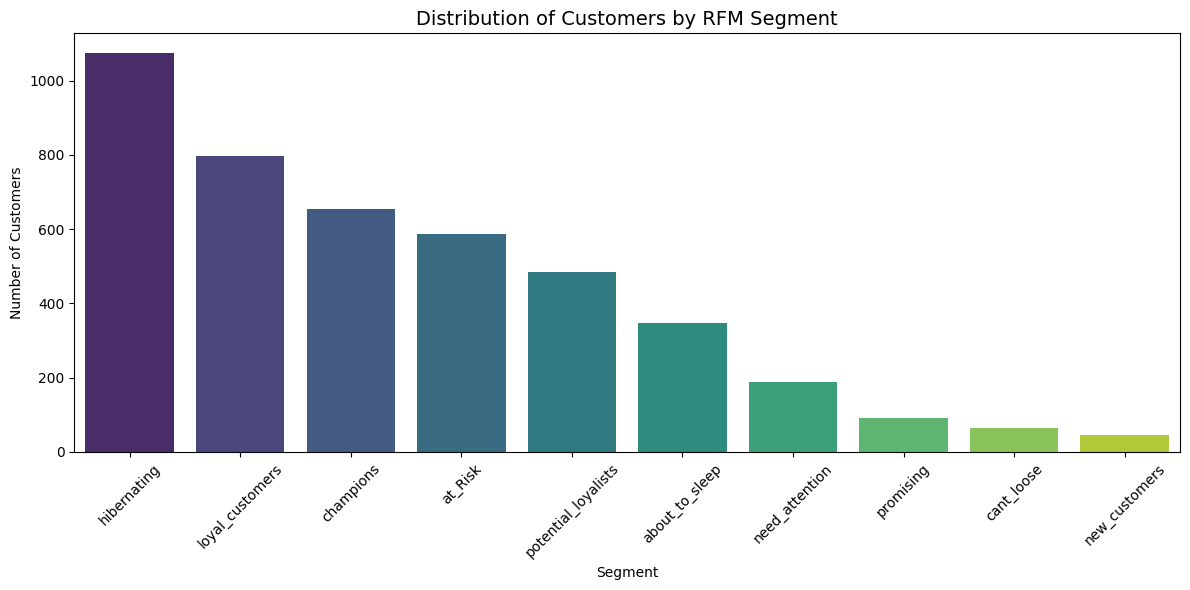

In [53]:
segment_counts = df[['CustomerID', 'segment']].drop_duplicates().groupby('segment').count().reset_index()
segment_counts.columns = ['segment', 'count']

# ترتيب الفئات حسب العدد
segment_counts = segment_counts.sort_values(by='count', ascending=False)

# الرسم
plt.figure(figsize=(12, 6))
sns.barplot(data=segment_counts, x='segment', y='count', palette='viridis')

plt.title('Distribution of Customers by RFM Segment', fontsize=14)
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

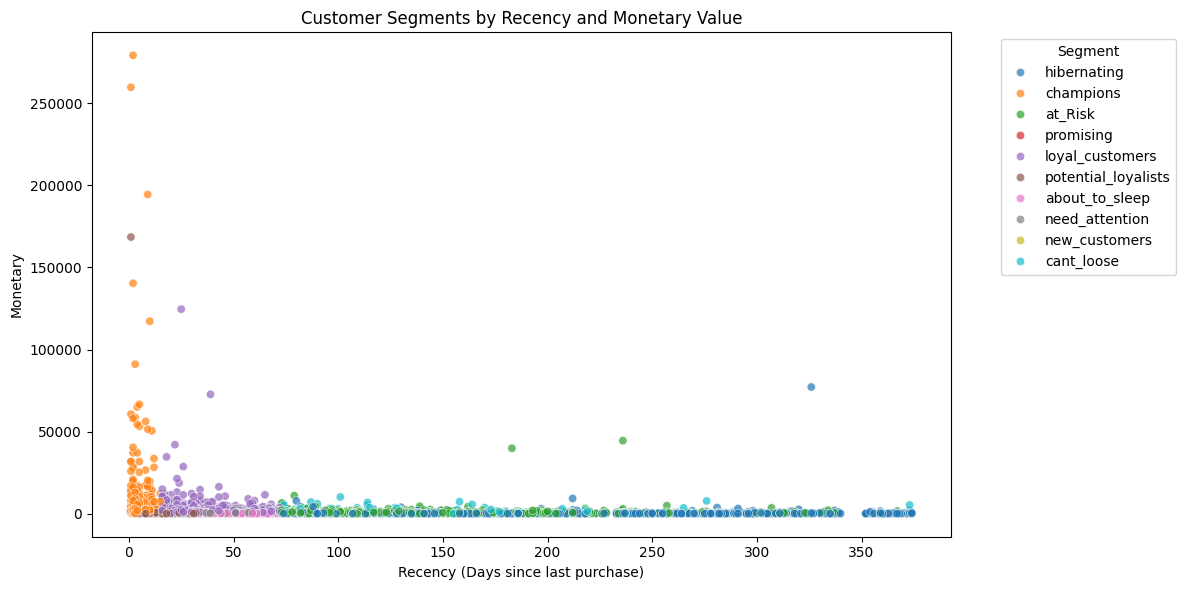

In [54]:
plt.figure(figsize=(12, 6))

sns.scatterplot(
    data=rfm,
    x='Recency',
    y='Monetary',
    hue='segment',
    palette='tab10',
    alpha=0.7
)

plt.title('Customer Segments by Recency and Monetary Value')
plt.xlabel('Recency (Days since last purchase)')
plt.ylabel('Monetary')
plt.legend(title='Segment', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [59]:
df.to_csv("Final_File.csv", index=False)

In [60]:
from google.colab import files
files.download("Final_File.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>